# Stacking Analysis -- usage

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u # I use astropy units in everything, very helpful for bookkeeping/debugging

#import sys 
#sys.path.append('..')

from lim import lim # The base intensity mapping object

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':[8,7]}) # Make figures better
#matplotlib.rcParams,update({}'figure.figsize'] = [8,7]

In [2]:
# Initialize LineModel with default model
m = lim()

In [3]:
lim_cii = lim('Lichen_v2',doSim=True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


- halo_centpix

In [4]:
def halo_centpix(lim_obj, halo_xpos, halo_ypos, halo_zpos):

    '''
    Parameters
    ----------

    halo_xpos: array_like
               list of RA coordinates of halos, from the original distribution of halos

    halo_ypos: array_like
               list of DEC coordinates of halos, from the original distribution of halos


    Returns
    -------

    halo_centpix_x: array_like
                    list of the x-pixel positions of halos, mapped on the lim map


    halo_centpix_x: array_like
                    list of the y-pixel positions of halos, mapped on the lim map

    '''

    halo_centpix_x = [0 for i in range(len(halo_xpos))]
    halo_centpix_y = [0 for i in range(len(halo_ypos))]
    halo_centpix_z = [0 for i in range(len(halo_zpos))]
    
    map_xs = lim_obj.mapinst.pix_bincents_x
    map_ys = lim_obj.mapinst.pix_bincents_y
    map_zs = (lim_obj.mapinst.nu_rest/lim_obj.mapinst.nu_bincents) - 1

    for i in range(len(halo_xpos)):
        halo_centpix_x[i] = np.argmin(np.abs(halo_xpos[i] - map_xs))
    for i in range(len(halo_ypos)):
        halo_centpix_y[i] = np.argmin(np.abs(halo_ypos[i] - map_ys))
    for i in range(len(halo_zpos)):
        halo_centpix_z[i] = np.argmin(np.abs(halo_zpos[i] - map_zs))    
    

    return halo_centpix_x, halo_centpix_y, halo_centpix_z

In [5]:
def halo_centpix_v2(lim_obj, halo_xpos, halo_ypos, halo_zpos):

    '''
    Parameters
    ----------

    halo_xpos: array_like
               list of RA coordinates of halos, from the original distribution of halos

    halo_ypos: array_like
               list of DEC coordinates of halos, from the original distribution of halos


    Returns
    -------

    halo_centpix_x: array_like
                    list of the x-pixel positions of halos, mapped on the lim map


    halo_centpix_x: array_like
                    list of the y-pixel positions of halos, mapped on the lim map

    '''

    map_xs = lim_obj.mapinst.pix_bincents_x
    map_ys = lim_obj.mapinst.pix_bincents_y
    map_zs = (lim_obj.mapinst.nu_rest/lim_obj.mapinst.nu_bincents) - 1
    
    pixcents_x_mesh, halo_xs_mesh = np.meshgrid(map_xs, halo_xpos)
    halo_centpix_x = np.argmin(np.abs(halo_xs_mesh - pixcents_x_mesh), axis=1)
    
    pixcents_y_mesh, halo_ys_mesh = np.meshgrid(map_ys, halo_ypos)
    halo_centpix_y = np.argmin(np.abs(halo_ys_mesh - pixcents_y_mesh), axis=1)
    
    pixcents_z_mesh, halo_zs_mesh = np.meshgrid(map_zs, halo_zpos)
    halo_centpix_z = np.argmin(np.abs(halo_zs_mesh - pixcents_z_mesh), axis=1)
    
    return halo_centpix_x, halo_centpix_y, halo_centpix_z

In [6]:
err = 0.03
mass_cut = 2*(10**10)
ind = 3

In [7]:
thresh = lim_cii.halos.M > mass_cut

map_zs = (lim_cii.mapinst.nu_rest/lim_cii.mapinst.nu_bincents) - 1

halo_zs = lim_cii.halos.redshift[thresh]

good_halo_zs = np.where(np.logical_and(halo_zs >= map_zs[ind] - err, halo_zs <= map_zs[ind] + err))

halo_xs = lim_cii.halos.ra[thresh][good_halo_zs]
halo_ys = lim_cii.halos.dec[thresh][good_halo_zs]
halo_zs = lim_cii.halos.redshift[thresh][good_halo_zs]

Loading .npz catalogues...


In [9]:
%%time
hc = halo_centpix(lim_cii, halo_xs, halo_ys, halo_zs)

CPU times: user 1.55 s, sys: 50.7 ms, total: 1.6 s
Wall time: 1.58 s


In [10]:
%%time
halo_centpix_v2(lim_cii, halo_xs, halo_ys, halo_zs)

CPU times: user 221 ms, sys: 192 ms, total: 413 ms
Wall time: 416 ms


(array([129, 128, 106, ..., 208, 214, 220]),
 array([218, 237, 232, ...,  22,  19,  15]),
 array([4, 4, 4, ..., 4, 4, 4]))

The meshgrid computation takes about 10 times less time! v2 is much better

### Vectorization Exploration

Sample run to understand

In [61]:
from scipy.spatial import KDTree

In [144]:
data = np.random.rand(100,2) # grid on which we wish to map out cloud of points
sample = np.random.rand(80,2) # cloud of points
kdtree = KDTree(data)

In [180]:
dist, points = kdtree.query(sample) # distance and indices of nearest neighbors

In [183]:
plot_data = data.T
plot_sample = sample.T
plot_points = points.T

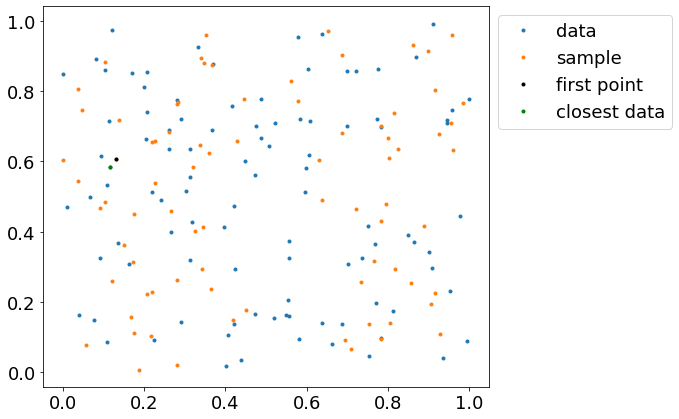

In [185]:
plt.plot(plot_data[0], plot_data[1], '.', label = 'data')
plt.plot(plot_sample[0], plot_sample[1], '.', label = 'sample')

plt.plot(plot_sample[0][0], plot_sample[1][0], '.k', label = 'first point')
plt.plot(plot_data[0][points[0]], plot_data[1][points[0]], '.g', label = 'closest data')

plt.legend(bbox_to_anchor = [1, 1])

Define new version of function using the nearest neighbors' tree:

In [250]:
def halo_centpix_v3(lim_obj, halo_xpos, halo_ypos, halo_zpos):

    map_xs = lim_obj.mapinst.pix_bincents_x
    map_ys = lim_obj.mapinst.pix_bincents_y
    map_zs = (lim_obj.mapinst.nu_rest/lim_obj.mapinst.nu_bincents) - 1
    
    map_data = np.reshape(np.transpose(np.meshgrid(map_xs, map_ys, map_zs)), 
                          [len(map_xs)*len(map_ys)*len(map_zs), 3])

    halo_sample = np.transpose(np.array([halo_xs, halo_ys, halo_zs]))
    
    tree = KDTree(map_data)

    _, points = tree.query(halo_sample)
    
    return map_data[points]

In [257]:
%%time
halo_centpix_v3(lim_cii, halo_xs, halo_ys, halo_zs)

CPU times: user 3.52 s, sys: 88.1 ms, total: 3.6 s
Wall time: 3.62 s


array([[-0.26912181,  0.23512748,  5.89818182],
       [-0.27478754,  0.3427762 ,  5.89818182],
       [-0.39943343,  0.31444759,  5.89818182],
       ...,
       [ 0.17847025, -0.87535411,  5.89818182],
       [ 0.21246459, -0.89235127,  5.89818182],
       [ 0.24645892, -0.91501416,  5.89818182]])

It works! But two problems: 
- 1) the returning output is not what I wanted (the index of the mapped positions): it's the mapped positions themselves. But because I reshaped arrays to run the tree, it's not trivial to retrieve the indices that I want.
- 2) It takes quite more time (3-4 s on average)
- Albeit I won't use that tool for now, it's good that I made it work and that I understand how it works. It may be very useful for other future problems.

So for now, the best halo_centpix function to use is the v2

- halo_map

In [13]:
def halo_map(lim_obj, n, halo_xpos, halo_ypos, halo_zpos):

    halo_mapx = [0 for i in range(len(halo_xpos))]
    halo_mapy = [0 for i in range(len(halo_ypos))]

    halo_centpix_x, halo_centpix_y, _ = halo_centpix_v2(lim_obj, halo_xpos, halo_ypos, halo_zpos)

    for i in range(len(halo_xpos)):
        halo_mapx[i] = np.linspace(halo_centpix_x[i] - ((n - 1)/2), halo_centpix_x[i] + ((n - 1)/2), n)
    for i in range(len(halo_ypos)):
        halo_mapy[i] = np.linspace(halo_centpix_y[i] - ((n - 1)/2), halo_centpix_y[i] + ((n - 1)/2), n)

    return halo_mapx, halo_mapy

In [15]:
%%time
hm = halo_map(lim_cii, 11, halo_xs, halo_ys, halo_zs)

CPU times: user 6.46 s, sys: 475 ms, total: 6.94 s
Wall time: 6.86 s


In [16]:
def halo_map_v2(lim_obj, n, halo_xpos, halo_ypos, halo_zpos):

    halo_mapx = [0 for i in range(len(halo_xpos))]
    halo_mapy = [0 for i in range(len(halo_ypos))]

    halo_centpix_x, halo_centpix_y, _ = halo_centpix_v2(lim_obj, halo_xpos, halo_ypos, halo_zpos)

    halo_mapx = np.linspace(halo_centpix_x - ((n - 1)/2), halo_centpix_x + ((n - 1)/2), n, axis = 1)
    halo_mapy = np.linspace(halo_centpix_y - ((n - 1)/2), halo_centpix_y + ((n - 1)/2), n, axis = 1)

    return halo_mapx, halo_mapy

In [25]:
%%time
halo_mapx, halo_mapy = halo_map_v2(lim_cii, 11, halo_xs, halo_ys, halo_zs)

CPU times: user 231 ms, sys: 185 ms, total: 417 ms
Wall time: 418 ms


- lum

In [18]:
def lum(lim_obj, ind, n, halo_xpos, halo_ypos, halo_zpos):

    halo_mapx, halo_mapy = halo_map(lim_obj, n, halo_xpos, halo_ypos, halo_zpos)
    
    npix_x, npix_y = lim_obj.mapinst.npix_x + 1, lim_obj.mapinst.npix_y + 1
    n_halos = len(halo_xpos)

    lum_pure = [[[[] for i in range(n)] for j in range(n)] for k in range(n_halos)]
    lum_noisy= [[[[] for i in range(n)] for j in range(n)] for k in range(n_halos)]

    pure_map = lim_obj.maps.value
    noisy_map = lim_obj.noise_added_map
    
    for i in range(n_halos):
        for j in range(len(halo_mapx[i])):
            for k in range(len(halo_mapy[i])):
                if int(halo_mapx[i][j]) < npix_x:
                    if int(halo_mapy[i][k]) < npix_y:
                            lum_pure[i][j][k] = pure_map[int(halo_mapx[i][j]), int(halo_mapy[i][k]), ind]
                            lum_noisy[i][j][k]= noisy_map[int(halo_mapx[i][j]), int(halo_mapy[i][k]), ind]
                    else:
                        lum_pure[i][j][k] = np.nan
                        lum_noisy[i][j][k]= np.nan
                else:
                    lum_pure[i][j][k] = np.nan
                    lum_noisy[i][j][k]= np.nan
        
    return lum_pure, lum_noisy

In [19]:
%%time
pure_cii, noisy_cii = lum(lim_cii, 3, 11, halo_xs, halo_ys, halo_zs)

CPU times: user 3min 41s, sys: 1.77 s, total: 3min 43s
Wall time: 3min 45s


In [21]:
(60*3 + 45)/10

22.5

In [26]:
def halo_map_v3(lim_obj, n, halo_xpos, halo_ypos, halo_zpos):

    halo_centpix_x, halo_centpix_y, halo_centpix_z = halo_centpix_v2(lim_obj, halo_xpos, halo_ypos, halo_zpos)

    halo_mapx = np.linspace(halo_centpix_x - ((n - 1)/2), halo_centpix_x + ((n - 1)/2), n, axis = 1)
    halo_mapy = np.linspace(halo_centpix_y - ((n - 1)/2), halo_centpix_y + ((n - 1)/2), n, axis = 1)
    halo_mapz = halo_centpix_z
    
    npix_x, npix_y = lim_obj.mapinst.npix_x + 1, lim_obj.mapinst.npix_y + 1
    outb_x = halo_mapx >= npix_x
    outb_y = halo_mapy >= npix_y
    
    halo_mapx[outb_x] = None
    halo_mapy[outb_y] = None
    
    return halo_mapx, halo_mapy, halo_mapz

In [174]:
def inbound_halos(lim_obj, n, halo_xpos, halo_ypos, halo_zpos):
    
    halo_mapx, halo_mapy, halo_mapz = halo_map_v3(lim_obj, n, halo_xpos, halo_ypos, halo_zpos)

    inb_x = ~np.isnan(halo_mapx).any(axis = 1)
    inb_y = ~np.isnan(halo_mapy).any(axis = 1)
    
    inb = np.logical_and(inb_x, inb_y)
            
    return halo_mapx, halo_mapy, halo_mapz, inb

In [172]:
_, _, _, inb_tot = inbound_halos_new(lim_cii, 11, halo_xs, halo_ys, halo_zs)

In [ ]:
inb_tot = np.logical_and(inb_x, )

In [173]:
len(halo_xs[inb_tot])

44063

In [154]:
len(halo_xs[inb_x][inb_y])

44063

In [156]:
len(halo_zs)

44709

In [157]:
len(inb_tot)

44709

- new exploration for collecting luminosities

In [29]:
%%time
halo_mapx, halo_mapy, halo_mapz, inb_x, inb_y = inbound_halos(lim_cii, 11, halo_xs, halo_ys, halo_zs)

CPU times: user 214 ms, sys: 214 ms, total: 428 ms
Wall time: 430 ms


In [42]:
halo_mapz

array([4, 4, 4, ..., 4, 4, 4])

In [52]:
halo_mapx_in = halo_mapx[inb_x][inb_y].astype(int)
halo_mapy_in = halo_mapy[inb_x][inb_y].astype(int)
halo_mapz_in = halo_mapz[inb_x][inb_y]

In [67]:
%%time
wht = pure_map[halo_mapx_in]

CPU times: user 12 s, sys: 16.6 s, total: 28.6 s
Wall time: 29 s


In [72]:
%%time
sig_x = np.take(pure_map, halo_mapx_in, axis = 0)

CPU times: user 11.4 s, sys: 18.3 s, total: 29.7 s
Wall time: 30.1 s


In [75]:
%%time
np.shape(sig_x[:, ])

CPU times: user 30 µs, sys: 0 ns, total: 30 µs
Wall time: 42 µs


(44063, 11, 354, 54)

In [76]:
halo_mapx_in[0]

array([124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134])

In [78]:
halo_mapy_in[0]

array([213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223])

In [84]:
np.shape(pure_map[halo_mapx_in[0], halo_mapy_in[0]])

(11, 54)

In [100]:
halo_mapz_in[0]

4

In [97]:
%time
grid_0 = np.meshgrid(halo_mapx_in[0], halo_mapy_in[0], halo_mapz_in[0])

CPU times: user 9 µs, sys: 2 µs, total: 11 µs
Wall time: 23.1 µs


In [104]:
grid_0 = np.reshape(grid_0, (3, 11, 11))

In [105]:
np.shape(pure_map[grid_0[0], grid_0[1], grid_0[2]])

(11, 11)

In [119]:
n_halos = len(halo_xs[inb_x][inb_y])
grid = [0 for i in range(n_halos)]
sigs = [0 for i in range(n_halos)]

for i in range(len(halo_xs[inb_x][inb_y])):
    
    grid[i] = np.meshgrid(halo_mapx_in[i], halo_mapy_in[i], halo_mapz_in[i])
    sigs[i] = pure_map[grid[i][0], grid[i][1], grid[i][2]]

sigs = np.reshape(sigs, (n_halos, 11, 11))

In [120]:
np.shape(sigs)

(44063, 11, 11)

In [122]:
avg_sig = np.nanmean(sigs, axis = 0)

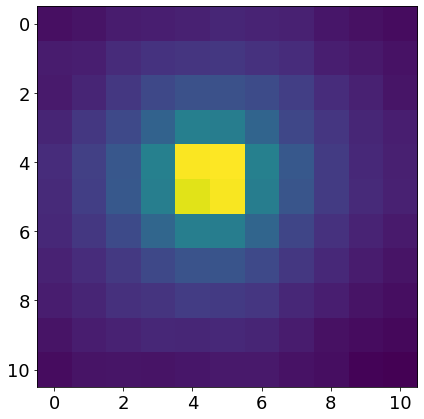

In [124]:
plt.imshow(avg_sig)

In [132]:
len(inb_y)

44416

In [133]:
len(inb_x)

44709

In [134]:
np.logical_and(inb_x, inb_y)

ValueError: operands could not be broadcast together with shapes (44709,) (44416,) 

In [185]:
def lum_v3(lim_obj, n, halo_xpos, halo_ypos, halo_zpos):

    halo_mapx, halo_mapy, halo_mapz, inb = inbound_halos(lim_obj, n, halo_xpos, halo_ypos, halo_zpos)
    
    inb_mapx = halo_mapx[inb].astype(int)
    inb_mapy = halo_mapy[inb].astype(int)
    inb_mapz = halo_mapz[inb].astype(int)

    nhalos = len(inb_mapx)
    
    pure_map = lim_obj.maps.value
    noisy_map= lim_obj.noise_added_map
    
    grid = [0 for i in range(nhalos)]
    sigs = [0 for i in range(nhalos)]
    noisy= [0 for i in range(nhalos)]
    
    for i in range(nhalos):
    
        grid[i] = np.meshgrid(inb_mapx[i], inb_mapy[i], inb_mapz[i])
        sigs[i] = pure_map[grid[i][0], grid[i][1], grid[i][2]]
        noisy[i]= noisy_map[grid[i][0], grid[i][1], grid[i][2]]
        
    sigs = np.reshape(sigs, (nhalos, n, n))
    noisy= np.reshape(noisy, (nhalos, n, n))
    
    return sigs, noisy

In [202]:
%%time
pure_sig, noisy_sig = lum_v3(lim_cii, 50, halo_xs, halo_ys, halo_zs )

CPU times: user 18.1 s, sys: 3 s, total: 21.1 s
Wall time: 21.3 s


Text(0.5, 0, '$RA-pixels$')

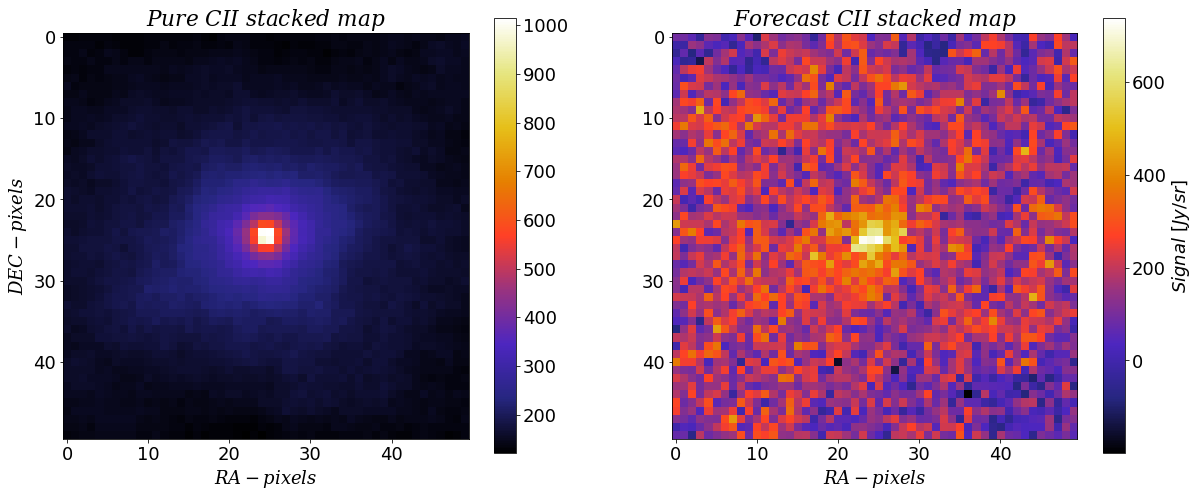

In [203]:
fig , axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8))

plt.subplot(121)
plt.imshow(np.nanmean(pure_sig, axis = 0), cmap = 'CMRmap')
plt.colorbar()
plt.title(r'$Pure\ CII\ stacked\ map$', math_fontfamily = 'dejavuserif')
plt.xlabel(r'$RA-pixels$', math_fontfamily='dejavuserif')
plt.ylabel(r'$DEC-pixels$', math_fontfamily='dejavuserif')

plt.subplot(122)
plt.imshow(np.nanmean(noisy_sig, axis = 0), cmap = 'CMRmap')
plt.colorbar(label = r'$Signal\ [Jy/sr]$')
plt.title(r'$Forecast\ CII\ stacked\ map$', math_fontfamily = 'dejavuserif')
plt.xlabel(r'$RA-pixels$', math_fontfamily='dejavuserif')

In [204]:
lim_cii.tobs

<Quantity 2000. h>

In [208]:
map_zs[3]

5.870422535211265

In [209]:
def pix_res(beam_width, map_dim_deg, map_dim_pix):
    '''
    beam_width in arcmin
    map_dim_pix in pixels
    map_dim_deg in degrees
    
    '''
    
    ang_res = (beam_width.to(u.arcmin))/2.355
    map_dim_deg.to(u.deg)
    
    
    return ang_res/((map_dim_deg/map_dim_pix)*(60*u.arcmin/u.deg))

In [216]:
pix_res(40*u.arcmin, 2*u.deg, 354)

<Quantity 50.10615711>

In [214]:
(500*u.arcsec).to(u.arcmin)

<Quantity 8.33333333 arcmin>

In [219]:
map_zs

array([5.78846918, 5.81556886, 5.84288577, 5.87042254, 5.89818182,
       5.92616633, 5.95437882, 5.98282209, 6.01149897, 6.04041237,
       6.06956522, 6.0989605 , 6.12860125, 6.15849057, 6.18863158,
       6.21902748, 6.24968153, 6.28059701, 6.3117773 , 6.34322581,
       6.374946  , 6.40694143, 6.43921569, 6.47177243, 6.50461538,
       6.53774834, 6.57117517, 6.60489978, 6.63892617, 6.67325843,
       6.70790068, 6.74285714, 6.77813212, 6.81372998, 6.84965517,
       6.88591224, 6.9225058 , 6.95944056, 6.99672131, 7.03435294,
       7.07234043, 7.11068884, 7.14940334, 7.18848921, 7.22795181,
       7.26779661, 7.3080292 , 7.34865526, 7.38968059, 7.43111111,
       7.47295285, 7.51521197, 7.55789474, 7.60100756])

In [226]:
def lum_v2(lim_obj, ind, n, halo_xpos, halo_ypos, halo_zpos):

    halo_mapx, halo_mapy, halo_mapz = halo_map_v3(lim_obj, n, halo_xpos, halo_ypos, halo_zpos)
    
    npix_x, npix_y = lim_obj.mapinst.npix_x + 1, lim_obj.mapinst.npix_y + 1
    n_halos = len(halo_xpos)

    pure_map = lim_obj.maps.value
    
    for i in range(n_halos):
        pure_x = np.take(pure_map, halo_mapx.astype(int)[i], axis = 0)
        pure_xy = np.take(sig_x, halo_mapy.astype(int)[i], axis = 1)
        pure_xyz = np.take(sig_xy, halo_mapz.astype(int)[i], axis = 2)
        
    return pure_xyz

In [320]:
halo_mapx, halo_mapy, halo_mapz = halo_map_v3(lim_cii, 11, halo_xs, halo_ys, halo_zs)

In [39]:
pure_map = lim_cii.maps.value
noisy_map = lim_cii.noise_added_map

In [170]:
halo_mapx.astype(int)

array([[124, 125, 126, ..., 132, 133, 134],
       [123, 124, 125, ..., 131, 132, 133],
       [101, 102, 103, ..., 109, 110, 111],
       ...,
       [203, 204, 205, ..., 211, 212, 213],
       [209, 210, 211, ..., 217, 218, 219],
       [215, 216, 217, ..., 223, 224, 225]])

In [215]:
sig_x = np.take(pure_map, halo_mapx.astype(int)[0], axis = 0)
sig_xy = np.take(sig_x, halo_mapy.astype(int)[0], axis = 1)
sig_xyz = np.take(sig_xy, halo_mapz.astype(int)[0], axis = 2)

In [322]:
halo_mapx[1951]

array([345., 346., 347., 348., 349., 350., 351., 352., 353.,  nan,  nan])

In [342]:
halo_mapx_new = halo_mapx[~np.isnan(halo_mapx).any(axis = 1)]
halo_mapy_new = halo_mapy[~np.isnan(halo_mapy).any(axis = 1)]

In [348]:
halo_mapx[~np.isnan(halo_mapx).any(axis = 1)]

array([[124., 125., 126., ..., 132., 133., 134.],
       [123., 124., 125., ..., 131., 132., 133.],
       [101., 102., 103., ..., 109., 110., 111.],
       ...,
       [203., 204., 205., ..., 211., 212., 213.],
       [209., 210., 211., ..., 217., 218., 219.],
       [215., 216., 217., ..., 223., 224., 225.]])

In [333]:
halo_mapx[1952]

array([314., 315., 316., 317., 318., 319., 320., 321., 322., 323., 324.])

In [335]:
halo_mapx_new[1951]

array([314., 315., 316., 317., 318., 319., 320., 321., 322., 323., 324.])

In [338]:
len(halo_mapx_new)/len(halo_mapx)

0.9934465096513007

In [340]:
len(halo_mapy_new)/len(halo_mapy)

0.9920597642532824

In [27]:
def inbound_halos(lim_obj, n, halo_xpos, halo_ypos, halo_zpos):
    
    halo_mapx, halo_mapy, halo_mapz = halo_map_v3(lim_obj, n, halo_xpos, halo_ypos, halo_zpos)

    inbound_x = ~np.isnan(halo_mapx).any(axis = 1)
    inbound_y = ~np.isnan(halo_mapy[inbound_x]).any(axis = 1)
        
    return halo_mapx, halo_mapy, halo_mapz, inbound_x, inbound_y

In [ ]:
def halo_map_v3(lim_obj, n, halo_xpos, halo_ypos, halo_zpos):

    halo_centpix_x, halo_centpix_y, halo_centpix_z = halo_centpix_v2(lim_obj, halo_xpos, halo_ypos, halo_zpos)

    halo_mapx = np.linspace(halo_centpix_x - ((n - 1)/2), halo_centpix_x + ((n - 1)/2), n, axis = 1)
    halo_mapy = np.linspace(halo_centpix_y - ((n - 1)/2), halo_centpix_y + ((n - 1)/2), n, axis = 1)
    halo_mapz = halo_centpix_z
    
    npix_x, npix_y = lim_obj.mapinst.npix_x + 1, lim_obj.mapinst.npix_y + 1
    outb_x = halo_mapx >= npix_x
    outb_y = halo_mapy >= npix_y
    
    halo_mapx[outb_x] = None
    halo_mapy[outb_y] = None
    
    return halo_mapx, halo_mapy, halo_mapz

In [ ]:
def lum_v3(lim_obj, ind, n, halo_xpos, halo_ypos, halo_zpos):

    halo_mapx, halo_mapy, halo_mapz, inb_x, inb_y = inbound_halos(lim_obj, n, halo_xpos, halo_ypos, halo_zpos)
    
    good_mapx = halo_mapx[inb_x][inb_y]
    good_mapy = halo_mapy[inb_x][inb_y]

    pure_map = lim_obj.maps.value
    
    pure_x = np.take(pure_map, halo_mapx.astype(int)[i], axis = 0)
    pure_xy = np.take(sig_x, halo_mapy.astype(int)[i], axis = 1)
    pure_xyz = np.take(sig_xy, halo_mapz.astype(int)[i], axis = 2)
        
    return pure_xyz

In [367]:
%%time
halo_mapx, halo_mapy, halo_mapz, inb_x, inb_y = inbound_halos(lim_cii, 11, halo_xs, halo_ys, halo_zs)

CPU times: user 233 ms, sys: 196 ms, total: 429 ms
Wall time: 432 ms


In [ ]:
%%time
np.meshgrid(halo_mapx[inb_x][inb_y], halo_mapy[inb_x][inb_y])

In [288]:
halo_mapx = halo_mapx[np.isfinite(halo_mapx)]

In [297]:
np.where(np.isfinite(halo_mapx), halo_mapx, 2)

array([124., 125., 126., ..., 223., 224., 225.])

In [285]:
halo_mapx

array([124., 125., 126., ..., 223., 224., 225.])

In [243]:
import pandas as pd

In [299]:
df = pd.DataFrame(halo_mapx)

In [300]:
df = df[df.notnull()]

In [303]:
df = df.T

In [277]:
new_df = df.T

In [279]:
new_df[[1951]]

,1951
0,345.0
1,346.0
2,347.0
3,348.0
4,349.0
5,350.0
6,351.0
7,352.0
8,353.0
9,NaN


In [77]:
%%time
pure_cii, noisy_cii = lum_v2(lim_cii, 3, 11, halo_xs, halo_ys, halo_zs)

IndexError: arrays used as indices must be of integer (or boolean) type

Text(0.5, 0, '$RA-pixels$')

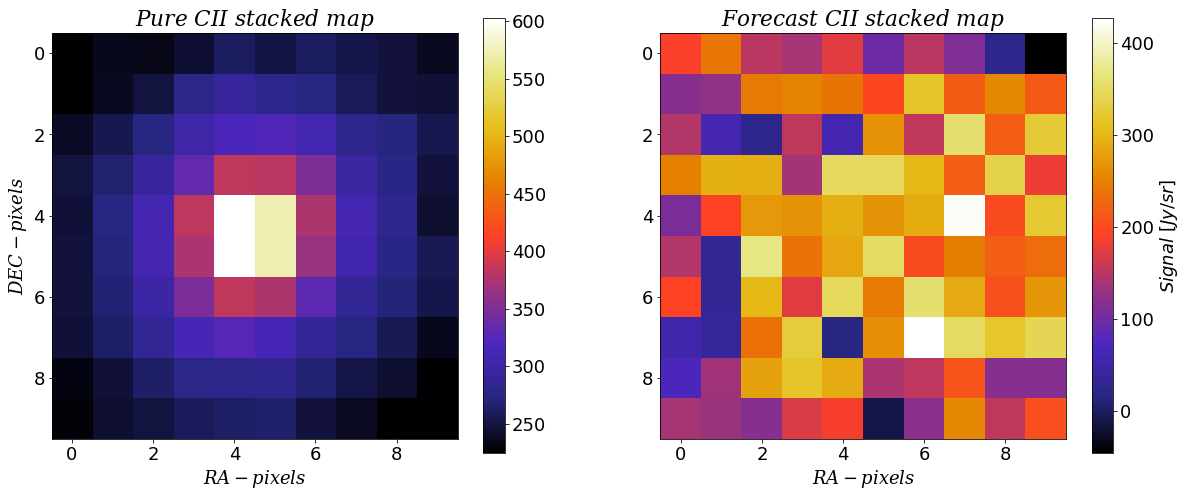

In [17]:
fig , axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8))

plt.subplot(121)
plt.imshow(np.nanmean(pure_cii, axis = 0), cmap = 'CMRmap')
plt.colorbar()
plt.title(r'$Pure\ CII\ stacked\ map$', math_fontfamily = 'dejavuserif')
plt.xlabel(r'$RA-pixels$', math_fontfamily='dejavuserif')
plt.ylabel(r'$DEC-pixels$', math_fontfamily='dejavuserif')

plt.subplot(122)
plt.imshow(np.nanmean(noisy_cii, axis = 0), cmap = 'CMRmap')
plt.colorbar(label = r'$Signal\ [Jy/sr]$')
plt.title(r'$Forecast\ CII\ stacked\ map$', math_fontfamily = 'dejavuserif')
plt.xlabel(r'$RA-pixels$', math_fontfamily='dejavuserif')

In [47]:
halo_mapx, halo_mapy = halo_map_v2(lim_cii, 11, halo_xs, halo_ys, halo_zs)

In [27]:
halo_centpix_x, halo_centpix_y, _ = halo_centpix_v2(lim_cii, halo_xs, halo_ys, halo_zs)

In [31]:
halo_centpix_x[0]

129

In [34]:
halo_mapx[0]

array([124., 125., 126., 127., 128., 129., 130., 131., 132., 133., 134.])

## G/Non-G Debugging (June 9)

In [1]:
from stacking_utils import *

### stacking_params:

In [2]:
# Set the limlam_mocker object
#m = lim()
lim_sim = lim('Lichen_v4', doSim=True)

# Update parameters as desired: tobs for noise, catalogue_file for input lightcone
# Be aware: make sure to adapt nuObs and Delta_nu to your lightcone
# dnu for the amount of redshift slices

t_obs = 100000 * u.hr
lim_sim.update(model_par = {'zdex': 0.3,
 'M0': 1900000000.0,
 'Mmin': 20000000000,
 'alpha_MH1': 0.74,
 'alpha_LCII': 0.017,
 'BehrooziFile': 'sfr_reinterp.dat'}, 
             tobs = t_obs,
             nuObs = 400*u.GHz,
             Delta_nu = 28*u.GHz,
             Omega_field = 16*(u.deg**2),
               catalogue_file = '/mnt/scratch-lustre/horlaville/nate_sims/june_9/gaussian/gauss_lc_0.npz')

# Lower bound of halo masses to be considered
mass_cut = 2*(10**10) # in Solar masses

# Error of acceptance on the redshift of the 2D map for surrounding halos
err = 0.03

# Index of the redshift map to be selected. There are 21 redshift slices by default, so ind can be any integer between 0 and 20
ind = 3

# Size of the stacked map to be produced (n by n)
n = 10

# Size of the stacked map, in angular dimension
ang_side = np.sqrt(lim_sim.Omega_field)
nside = lim_sim.Nside
stack_dim = round(n*(ang_side/nside).value, 2)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


### stacking

In [6]:
thresh = lim_sim.halos.M > mass_cut

map_zs = (lim_sim.mapinst.nu_rest/lim_sim.mapinst.nu_bincents) - 1

halo_zs = lim_sim.halos.redshift[thresh]
good_halo_zs = np.where(np.logical_and(halo_zs >= map_zs[ind] - err, halo_zs <= map_zs[ind] + err))

halo_xs = lim_sim.halos.ra[thresh][good_halo_zs]
halo_ys = lim_sim.halos.dec[thresh][good_halo_zs]
halo_zs = halo_zs[good_halo_zs]

print('The total forecast observing time has been set to', t_obs, '.')
print('Redshift of selected slice is', round(map_zs[ind], 3), ', and accepted halos are in the redshift range [', round(map_zs[ind] - err, 3), ',', round(map_zs[ind] + err, 3), '].')
print('Stacked map is', n, 'by', n, ', which covers', stack_dim, 'deg by', stack_dim, 'deg.')

The total forecast observing time has been set to 100000.0 h .
Redshift of selected slice is 3.626 , and accepted halos are in the redshift range [ 3.596 , 3.656 ].
Stacked map is 10 by 10 , which covers 0.06 deg by 0.06 deg.


In [10]:
pure_map, noisy_map = lum(lim_sim, n, halo_xs, halo_ys, halo_zs)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274


IndexError: index 706 is out of bounds for axis 0 with size 706

In [ ]:
halo_mapx, halo_mapy, halo_mapz, inb = inbound_halos(lim_obj, n, halo_xpos, halo_ypos, halo_zpos)
    
inb_mapx = halo_mapx[inb].astype(int)
inb_mapy = halo_mapy[inb].astype(int)
inb_mapz = halo_mapz[inb].astype(int)

nhalos = len(inb_mapx)
    
pure_map = lim_obj.maps.value
noisy_map= lim_obj.noise_added_map

grid = [0 for i in range(nhalos)]
sigs = [0 for i in range(nhalos)]
noisy= [0 for i in range(nhalos)]

In [ ]:
def lum(lim_obj, n, halo_xpos, halo_ypos, halo_zpos):

    halo_mapx, halo_mapy, halo_mapz, inb = inbound_halos(lim_obj, n, halo_xpos, halo_ypos, halo_zpos)
    
    inb_mapx = halo_mapx[inb].astype(int)
    inb_mapy = halo_mapy[inb].astype(int)
    inb_mapz = halo_mapz[inb].astype(int)

    nhalos = len(inb_mapx)
    
    pure_map = lim_obj.maps.value
    noisy_map= lim_obj.noise_added_map
    
    grid = [0 for i in range(nhalos)]
    sigs = [0 for i in range(nhalos)]
    noisy= [0 for i in range(nhalos)]
    
    for i in range(nhalos):
    
        grid[i] = np.meshgrid(inb_mapx[i], inb_mapy[i], inb_mapz[i])
        print(i)
        sigs[i] = pure_map[grid[i][0], grid[i][1], grid[i][2]]
        noisy[i]= noisy_map[grid[i][0], grid[i][1], grid[i][2]]
        
    sigs = np.reshape(sigs, (nhalos, n, n))
    noisy= np.reshape(noisy, (nhalos, n, n))
    
    return sigs, noisy

In [11]:
def inbound_halos(lim_obj, n, halo_xpos, halo_ypos, halo_zpos):
    
    halo_mapx, halo_mapy, halo_mapz = halo_map(lim_obj, n, halo_xpos, halo_ypos, halo_zpos)

    inb_x = ~np.isnan(halo_mapx).any(axis = 1)
    inb_y = ~np.isnan(halo_mapy).any(axis = 1)
    
    inb = np.logical_and(inb_x, inb_y)
            
    return halo_mapx, halo_mapy, halo_mapz, inb

In [12]:
def halo_map(lim_obj, n, halo_xpos, halo_ypos, halo_zpos):

    halo_centpix_x, halo_centpix_y, halo_centpix_z = halo_centpix(lim_obj, halo_xpos, halo_ypos, halo_zpos)

    halo_mapx = np.linspace(halo_centpix_x - ((n - 1)/2), halo_centpix_x + ((n - 1)/2), n, axis = 1)
    halo_mapy = np.linspace(halo_centpix_y - ((n - 1)/2), halo_centpix_y + ((n - 1)/2), n, axis = 1)
    halo_mapz = halo_centpix_z
    
    npix_x, npix_y = lim_obj.mapinst.npix_x + 1, lim_obj.mapinst.npix_y + 1
    outb_x = halo_mapx >= npix_x
    outb_y = halo_mapy >= npix_y
    
    halo_mapx[outb_x] = None
    halo_mapy[outb_y] = None
    
    return halo_mapx, halo_mapy, halo_mapz

In [13]:
def halo_centpix(lim_obj, halo_xpos, halo_ypos, halo_zpos):

    map_xs = lim_obj.mapinst.pix_bincents_x
    map_ys = lim_obj.mapinst.pix_bincents_y
    map_zs = (lim_obj.mapinst.nu_rest/lim_obj.mapinst.nu_bincents) - 1
    
    pixcents_x_mesh, halo_xs_mesh = np.meshgrid(map_xs, halo_xpos)
    halo_centpix_x = np.argmin(np.abs(halo_xs_mesh - pixcents_x_mesh), axis=1)
    
    pixcents_y_mesh, halo_ys_mesh = np.meshgrid(map_ys, halo_ypos)
    halo_centpix_y = np.argmin(np.abs(halo_ys_mesh - pixcents_y_mesh), axis=1)
    
    pixcents_z_mesh, halo_zs_mesh = np.meshgrid(map_zs, halo_zpos)
    halo_centpix_z = np.argmin(np.abs(halo_zs_mesh - pixcents_z_mesh), axis=1)
    
    return halo_centpix_x, halo_centpix_y, halo_centpix_z

In [16]:
mass_cut_t = 2*(10**10)
ind_t = 3
err_t = 0.03
n_t = 10

In [17]:
ang_side_t = np.sqrt(lim_sim.Omega_field)
nside_t = lim_sim.Nside
stack_dim_t = round(n_t*(ang_side_t/nside_t).value, 2)

In [21]:
thresh_t = lim_sim.halos.M > mass_cut_t

map_zs_t = (lim_sim.mapinst.nu_rest/lim_sim.mapinst.nu_bincents) - 1

halo_zs_t = lim_sim.halos.redshift[thresh_t]
good_halo_zs_t = np.where(np.logical_and(halo_zs_t >= map_zs_t[ind_t] - err_t, halo_zs_t <= map_zs_t[ind_t] + err_t))

halo_xs_t = lim_sim.halos.ra[thresh_t][good_halo_zs_t]
halo_ys_t = lim_sim.halos.dec[thresh_t][good_halo_zs_t]
halo_zs_t = halo_zs_t[good_halo_zs_t]

In [23]:
map_xs_t = lim_sim.mapinst.pix_bincents_x
map_ys_t = lim_sim.mapinst.pix_bincents_y
map_zs_t = (lim_sim.mapinst.nu_rest/lim_sim.mapinst.nu_bincents) - 1
    
pixcents_x_mesh_t, halo_xs_mesh_t = np.meshgrid(map_xs_t, halo_xs_t)
halo_centpix_x_t = np.argmin(np.abs(halo_xs_mesh_t - pixcents_x_mesh_t), axis=1)
    
pixcents_y_mesh_t, halo_ys_mesh_t = np.meshgrid(map_ys_t, halo_ys_t)
halo_centpix_y_t = np.argmin(np.abs(halo_ys_mesh_t - pixcents_y_mesh_t), axis=1)
    
pixcents_z_mesh_t, halo_zs_mesh_t = np.meshgrid(map_zs_t, halo_zs_t)
halo_centpix_z_t = np.argmin(np.abs(halo_zs_mesh_t - pixcents_z_mesh_t), axis=1)

Text(0.5, 1.0, 'Halos x position')

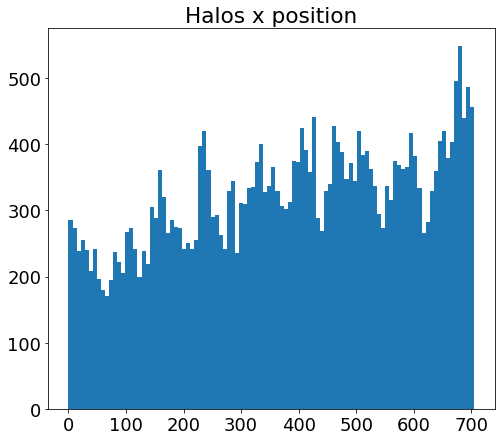

In [31]:
plt.hist(halo_centpix_x_t, bins = 100)
plt.title('Halos x position')

In [43]:
halo_mapx_t = np.linspace(halo_centpix_x_t - ((n_t - 1)/2), halo_centpix_x_t + ((n_t - 1)/2), n_t, axis = 1)
halo_mapy_t = np.linspace(halo_centpix_y_t - ((n_t - 1)/2), halo_centpix_y_t + ((n_t - 1)/2), n_t, axis = 1)
halo_mapz_t = halo_centpix_z_t
    
npix_x_t, npix_y_t = lim_sim.mapinst.npix_x , lim_sim.mapinst.npix_y 
outb_x_t = halo_mapx_t >= npix_x_t
outb_y_t = halo_mapy_t >= npix_y_t
    
halo_mapx_t[outb_x_t] = None
halo_mapy_t[outb_y_t] = None

In [46]:
inb_x_t = ~np.isnan(halo_mapx_t).any(axis = 1)
inb_y_t = ~np.isnan(halo_mapy_t).any(axis = 1)
    
inb_t = np.logical_and(inb_x_t, inb_y_t)

In [52]:
inb_mapx_t = halo_mapx_t[inb_t].astype(int)
inb_mapy_t = halo_mapy_t[inb_t].astype(int)
inb_mapz_t = halo_mapz_t[inb_t].astype(int)

nhalos_t = len(inb_mapx_t)
    
pure_map_t = lim_sim.maps.value
noisy_map_t = lim_sim.noise_added_map
    
grid_t = [0 for i in range(nhalos_t)]
sigs_t = [0 for i in range(nhalos_t)]
noisy_t = [0 for i in range(nhalos_t)]
    
for i in range(nhalos_t):
    
    grid_t[i] = np.meshgrid(inb_mapx_t[i], inb_mapy_t[i], inb_mapz_t[i])
    sigs_t[i] = pure_map_t[grid_t[i][0], grid_t[i][1], grid_t[i][2]]
    noisy_t[i] = noisy_map_t[grid_t[i][0], grid_t[i][1], grid_t[i][2]]
        
sigs_t = np.reshape(sigs_t, (nhalos_t, n_t, n_t))
noisy_t = np.reshape(noisy_t, (nhalos_t, n_t, n_t))

In [55]:
pure_stack_t, noisy_stack_t = np.nanmean(sigs_t, axis = 0), np.nanmean(noisy_t, axis = 0)

/tmp/ipykernel_2861555/1298124091.py:1: UserWarning: Attempting to set identical bottom == top == -0.03 results in singular transformations; automatically expanding.
  plt.imshow(pure_stack_t, extent = [-stack_dim_t/2, stack_dim_t/2, -stack_dim_t/2, -stack_dim_t/2])


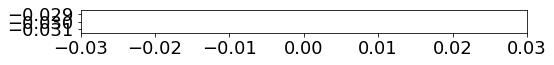

In [59]:
plt.imshow(pure_stack_t, extent = [-0.03, 0.03, -0.03, -stack_dim_t/2])

In [61]:
stack_dim_t/2

0.03

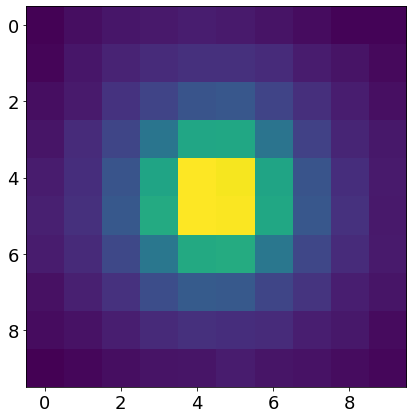

In [58]:
plt.imshow(noisy_stack_t)